In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
DATA_PATH = "Data/example-file.csv"

In [3]:
transactions_raw = pd.read_csv(DATA_PATH)
transactions_raw = transactions_raw.sort_values("LAST_TXN_DTE")
transactions_raw.head()

,COLLECTOR_KEY,LAST_TXN_DTE,FGC,target,trans,recency,pc,pci,si,flag_AIR,...,flag_ls_se,flag_f,flag_m,age,tenure,flag_on,dist,SHOPPED_L2W,LOADED_L2W,RECOMMENDED_L2W
130732,1294377,20160630,21084,0,0,NaN,185.0,1.972973,1.255373,0,...,0,1,0,61.0,26,0,0.575,0,0,0
40189,364654,20160630,111776,0,0,NaN,34.0,10.735294,1.200583,0,...,0,1,0,43.0,82,1,99.294,0,0,0
40190,364654,20160630,111778,0,0,NaN,63.0,5.793651,0.678551,0,...,0,1,0,43.0,82,1,99.294,0,0,0
172486,1660464,20160630,9604,0,0,NaN,90.0,4.055556,0.926189,0,...,0,1,0,55.0,85,1,163.274,0,0,0
36471,338037,20160630,71292,0,0,NaN,80.0,4.562500,1.218462,0,...,0,1,0,42.0,32,0,2.189,0,0,0


Number of users:  693

Order distribution: 


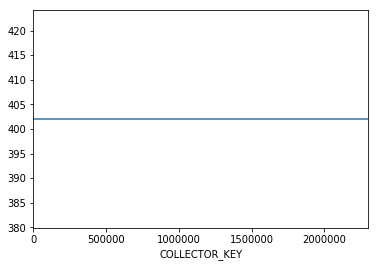

[402]


In [4]:
print("Number of users: ", len(transactions_raw["COLLECTOR_KEY"].unique()))
print()

print("Order distribution: ")
transactions_raw.groupby(by="COLLECTOR_KEY")["FGC"].count().plot()
plt.show()
print(transactions_raw.groupby(by="COLLECTOR_KEY")["FGC"].count().unique())

_Ok, so all users can be assumed to have exact same number of orders i.e. 402_

### Format categorical data

In [5]:
transactions_fgc_encoded = transactions_raw.copy()
#del transactions_raw

dummies = pd.get_dummies(transactions_raw["FGC"])

# Keep hold of new categories real values
dummyMapper = list(dummies.columns)

transactions_fgc_encoded = pd.concat([transactions_fgc_encoded, dummies], axis=1)
transactions_fgc_encoded = (transactions_fgc_encoded - transactions_fgc_encoded.min())/transactions_fgc_encoded.max()


del dummies
del transactions_raw

### Sort data and create a sequence based matrix

In [6]:
transactions_x = []
transactions_y = []

lim = 100

for name, group in transactions_fgc_encoded.groupby(by="COLLECTOR_KEY"):
    for i in range(0, len(group), lim):
        try:
            seq = group.values[i:i+lim-1,:]
            val = group.values[i+lim, -len(dummyMapper):]
            transactions_x.append(seq)
            transactions_y.append(val)
        except IndexError:
            break
del transactions_fgc_encoded

In [7]:
transactions_x = np.rollaxis(np.dstack(transactions_x), -1)
transactions_y = np.rollaxis(np.dstack(transactions_y), -1)

In [8]:
transactions_y = transactions_y.reshape(transactions_y.shape[0], transactions_y.shape[2])

In [9]:
transactions_y.shape
np.save("transactions_x", transactions_x)
np.save("transactions_y", transactions_y)

In [17]:
from keras.models import Sequential
from keras.layers import Dense, GRU, Dropout, Reshape

Using TensorFlow backend.


In [18]:
model = Sequential()
model.add(GRU(1024, input_shape=transactions_x.shape[1:]))
model.add(Reshape(target_shape=(32, 32)))
model.add(GRU(512, input_shape=transactions_x.shape[1:]))
model.add(Dropout(0.5))
#model.add(Dense(512))
model.add(Dense(len(dummyMapper), activation='sigmoid'))

In [19]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
model.fit(transactions_x, transactions_y, batch_size=50)

Epoch 1/10
 900/2772 [========>.....................] - ETA: 174s - loss: nan - acc: 0.0022